### Goal: Evaluation the time it take to compute CL lensing quantities using `cluster-toolkit` directly or the version wrapped into `CLMM` 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
from astropy.cosmology import FlatLambdaCDM
import cluster_toolkit as ct
from clmm import modeling

#### Define a cosmology and fix cluster concentration

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
concentration = 4 #arbitrary
Omega_m = cosmo.Om0
R_perp = np.logspace(-2, 1, 30) #Mpc/h comoving; distance on the sky

#### Compare the brute force approach between `CT` and `CLMM`, calling the function for each cluster available

In [4]:
# Generate a population of random clusters
N_cl = int(1e4)
pop_cl_mass = np.random.uniform(1.e13,1.e16, N_cl)
pop_cl_z = np.random.uniform(0.1,1.2, N_cl)

def brute_force_CT():
    res = np.zeros([N_cl,len(R_perp)])
    sigma_r_proj = np.logspace(-3, 4, 1000) # this is so that CT runs in the same way as how it's called in CLMM
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        Om = Omega_m*(1+z)**3. # Need Omega_m(z) in cluster-toolkit
        Sigma_nfw = ct.deltasigma.Sigma_nfw_at_R(sigma_r_proj, mass, concentration, Om)
        res[i] = ct.deltasigma.DeltaSigma_at_R(R_perp, sigma_r_proj, Sigma_nfw, mass, concentration, Om)

    return res
        
def brute_force_CLMM():
    res = np.zeros([N_cl,len(R_perp)])
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        res[i] = modeling.predict_excess_surface_density(R_perp, mass, concentration, z, cosmo=cosmo, 
                                                delta_mdef=200, halo_profile_model='nfw')
    return res
        


In [23]:
%timeit brute_force_CT()

2.12 s ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit brute_force_CLMM()

2.78 s ± 53.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Generate profiles on a grid before interpolating for each cluster in the population.

In [5]:
def grid_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp):
    sigma_r_proj = np.logspace(-3, 4, 1000) # this is so that CT runs in the same way as how it's called in CLMM
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            Om = Omega_m*(1+z)**3. # Need Omega_m(z) in cluster-toolkit
            Sigma_nfw = ct.deltasigma.Sigma_nfw_at_R(sigma_r_proj, mass, concentration, Om)
            res[i][j] = ct.deltasigma.DeltaSigma_at_R(R_perp, sigma_r_proj, Sigma_nfw, mass, concentration, Om)
    return res

def grid_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp):
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            res[i][j] = modeling.predict_excess_surface_density(R_perp, mass, concentration, z, cosmo=cosmo, 
                                                                 delta_mdef=200, halo_profile_model='nfw')
    return res       

def grid_clmm_gammat(cl_masses, cl_redshifts, src_z, R_perp):
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])    
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            res[i][j] = modeling.predict_reduced_tangential_shear(R_perp, mdelta=mass, cdelta=concentration, 
                                                           z_cluster=z, z_source=src_z, cosmo=cosmo, 
                                                           delta_mdef=200, halo_profile_model='nfw', 
                                                           z_src_model='single_plane')   
    return res

#### Define the mass and redshifts grids.
- 20 mass bins
- 20 redshifts bins

In [6]:
cl_masses = np.logspace(13.,16.,20)
cl_redshifts = np.linspace(0.1,1.2,20)

#### Time to generate the interpolation table

In [25]:
%timeit res_ct_DeltaSigma = grid_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp)

21 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit res_clmm_DeltaSigma = grid_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp)

28.7 ms ± 941 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It takes `CLMM` takes ~30% longer to generate the `DeltaSigma` profile than it does `cluster-toolkit`. Below, a sanity check to verify they did compute the same thing.

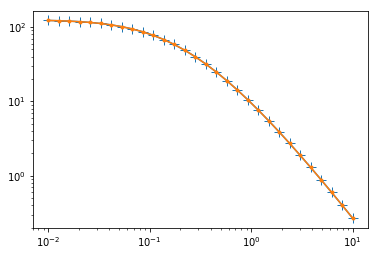

In [28]:
grid_ct = grid_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp)
grid_clmm = grid_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp)
plt.loglog(R_perp, grid_ct[1][2], marker='+', markersize=10)
plt.loglog(R_perp, grid_clmm[1][2], marker = '.')

#### Given the grid of profiles, interpolate for each cluster of the population. Trying 2 approaches:
- At a given radius, perform a 2D interpolation on mass and redshift. Means have as many interpolation function as there are radius bins
- Use a single 3D interpolation function in mass, z, and radius. 

In [29]:
from scipy import interpolate

def interpolation_CLMM(grid):
    interp_func={}
    for i,R in enumerate(R_perp): # Need one interpolation func at each point of the profile
        interp_func[R] = interpolate.RectBivariateSpline(np.log10(cl_masses), cl_redshifts, grid[:,:,i])

    res = np.zeros([N_cl,len(R_perp)])
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        res[i]=[interp_func[R](np.log10(mass),z)[0] for R in R_perp]

    return res

def interpolation_CT(grid):
    interp_func={}
    for i,R in enumerate(R_perp):
        interp_func[R] = interpolate.RectBivariateSpline(np.log10(cl_masses), cl_redshifts, grid[:,:,i])

    res = np.zeros([N_cl,len(R_perp)])
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        res[i]=[interp_func[R](np.log10(mass),z)[0] for R in R_perp]
        
    return res


def interpolation_CLMM2(grid):
    interp_f = interpolate.RegularGridInterpolator((np.log10(cl_masses),cl_redshifts,R_perp), grid)
    res = np.zeros([N_cl,len(R_perp)])
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        res[i]=[interp_f([np.log10(mass),z,R])[0] for R in R_perp]
    return res




In [30]:
%timeit interpolation_CT(grid_ct)

2.21 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit interpolation_CLMM(grid_clmm)

2.62 s ± 1.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit interpolation_CLMM2(grid_clmm)

1min 14s ± 936 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


3D interpolation uch longer than 2D interpolation. 2D interpolation similar to brute force in terms of execution time.

#### Checking the relative difference between brute force and interpolation
- For a 20 x 20 interpolation grid
- For a 10 x 10 interpolation grid

In [33]:
# Make the 20 x 20 grid
cl_masses = np.logspace(13.,16.,20)
cl_redshifts = np.linspace(0.1,1.2,20)
grid_clmm = grid_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp)

# Compute the DeltaSigma profile for the entire population
res_bruteforce_clmm = brute_force_CLMM()
res_interp_clmm = interpolation_CLMM(grid_clmm)
res_interp_clmm2 = interpolation_CLMM2(grid_clmm)

2D interp [20x20 grid] : max error of the full population: 0.04%
3D interp [20x20 grid] : max error of the full population: 1.34%


Text(0.5,1,'3D interpolation')

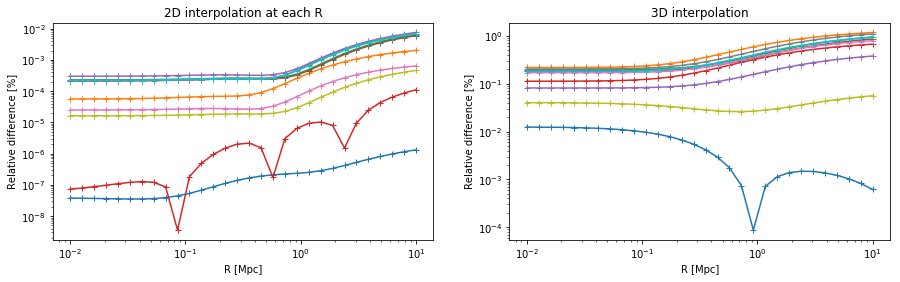

In [34]:
# Compare the profile for the 10 random clusters for the population
mask = random.sample(range(0,N_cl), 10)
rel_diff_clmm = (np.abs(res_bruteforce_clmm - res_interp_clmm))*100/res_bruteforce_clmm
rel_diff_clmm2 = (np.abs(res_bruteforce_clmm - res_interp_clmm2))*100/res_bruteforce_clmm

print(f"2D interp [20x20 grid] : max error of the full population: {np.max(rel_diff_clmm[:,-1]):.2f}%")
print(f"3D interp [20x20 grid] : max error of the full population: {np.max(rel_diff_clmm2[:,-1]):.2f}%")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
for res in rel_diff_clmm[mask]:
    axes[0].loglog(R_perp,res, marker='+')
for res in rel_diff_clmm2[mask]:
    axes[1].loglog(R_perp,res, marker='+')
axes[0].set_ylabel("Relative difference [%]")
axes[0].set_xlabel("R [Mpc]")
axes[0].set_title("2D interpolation at each R")

axes[1].set_ylabel("Relative difference [%]")
axes[1].set_xlabel("R [Mpc]")
axes[1].set_title("3D interpolation")

In [35]:
# Make the 10 x 10 grid
cl_masses = np.logspace(13.,16.,10)
cl_redshifts = np.linspace(0.1,1.2,10)
grid_clmm = grid_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp)

# Compute the DeltaSigma profile for the entire population
res_bruteforce_clmm = brute_force_CLMM()
res_interp_clmm = interpolation_CLMM(grid_clmm)

2D interp [10x10 grid] : max error of the full population: 0.65%


Text(0.5,0,'R [Mpc]')

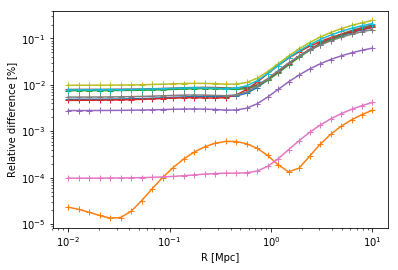

In [36]:
# Compare the profile for the 10 random clusters for the population
rel_diff_clmm = (np.abs(res_bruteforce_clmm - res_interp_clmm))*100/res_bruteforce_clmm
print(f"2D interp [10x10 grid] : max error of the full population: {np.max(rel_diff_clmm[:,-1]):.2f}%")

for res in rel_diff_clmm[mask]:
    plt.loglog(R_perp,res, marker='+')
plt.ylabel("Relative difference [%]")
plt.xlabel("R [Mpc]")

#### CLMM tangential shear profile computation for the same mass and redshift grid and a single source plane.

In [ ]:
z_src = 3.
%timeit res_clmm_gt = grid_clmm_gammat(cl_masses, cl_redshifts, z_src, R_perp)

The extra time compared to DeltaSigma comes from computing the angular diameter distances for Sigma_crit